# ARGA & ARVGA  

Paper:
* [Adversarially Regularized Graph Autoencoder for Graph Embedding](https://www.ijcai.org/Proceedings/2018/0362.pdf)  

## Imports

In [1]:
import torch
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

## Dataset

In [3]:
dataset = Planetoid('dataset', name='Cora', transform=T.NormalizeFeatures())
data = dataset.get(0)

In [4]:
num_nodes = data.x.shape[0]

In [5]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

## Models

In [6]:
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [8]:
def train():
    model.train()
    encoder_optimizer.zero_grad()

    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

    loss = 0
    loss = loss + model.reg_loss(z)  # Comment

    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()

    return loss

In [9]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

## Initialize the model

In [14]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(
    in_channels=latent_size, 
    hidden_channels=64,
    out_channels=1
) # Comment

In [15]:
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = model.to(device), data.to(device)

In [16]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

## Trainining

In [18]:
for epoch in range(1, 201):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    if epoch % 20 == 0:
        print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
               f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
               f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))

Epoch: 020, Loss: 3.989, AUC: 0.871, AP: 0.872, Completeness: 0.428, Homogeneity: 0.412, NMI: 0.420
Epoch: 040, Loss: 3.857, AUC: 0.893, AP: 0.897, Completeness: 0.451, Homogeneity: 0.430, NMI: 0.441
Epoch: 060, Loss: 3.754, AUC: 0.898, AP: 0.904, Completeness: 0.433, Homogeneity: 0.438, NMI: 0.435
Epoch: 080, Loss: 3.507, AUC: 0.901, AP: 0.909, Completeness: 0.297, Homogeneity: 0.306, NMI: 0.301
Epoch: 100, Loss: 3.479, AUC: 0.899, AP: 0.907, Completeness: 0.370, Homogeneity: 0.385, NMI: 0.377
Epoch: 120, Loss: 3.434, AUC: 0.893, AP: 0.902, Completeness: 0.366, Homogeneity: 0.375, NMI: 0.371
Epoch: 140, Loss: 3.287, AUC: 0.900, AP: 0.910, Completeness: 0.379, Homogeneity: 0.390, NMI: 0.385
Epoch: 160, Loss: 3.285, AUC: 0.908, AP: 0.911, Completeness: 0.377, Homogeneity: 0.385, NMI: 0.381
Epoch: 180, Loss: 3.271, AUC: 0.908, AP: 0.914, Completeness: 0.357, Homogeneity: 0.362, NMI: 0.360
Epoch: 200, Loss: 3.255, AUC: 0.908, AP: 0.916, Completeness: 0.279, Homogeneity: 0.288, NMI: 0.284


## Test & Visualization

In [19]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

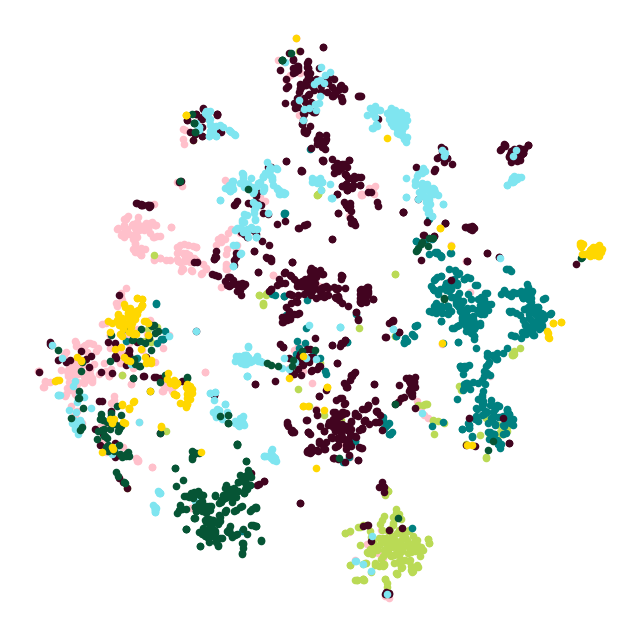

In [20]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)